
# Exploratory Data Analysis (EDA) for NYC Water Demand Forecasting

This notebook conducts an exploratory data analysis on the New York City water consumption data from 1979 to 2019. The goal is to understand the dataset's characteristics and identify trends and patterns that will inform the selection of forecasting models.

## Data Description

The dataset includes the following columns:

- **Year**: The year of the observation.
- **New York City Population**: The population of New York City in that year.
- **NYC Consumption (Million gallons per day)**: The total water consumption in New York City for that year, measured in million gallons per day.
- **Per Capita (Gallons per person per day)**: The average water consumption per person per day in gallons.

Let's start by loading the data and examining its basic properties.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [4]:
# Load the data
data = pd.read_csv('waterconsumption.csv')

In [ ]:
data.head()

,Year,Population,Consumption,Per Capita
0,1979,7102100.0,1512.0,213
1,1980,7071639.0,1506.0,213
2,1981,7089241.0,1309.0,185
3,1982,7109105.0,1382.0,194
4,1983,7181224.0,1424.0,198


In [5]:
# Display basic information and the first few rows of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         41 non-null     int64  
 1   Population   41 non-null     float64
 2   Consumption  41 non-null     float64
 3   Per Capita   41 non-null     int64  
dtypes: float64(2), int64(2)
memory usage: 1.4 KB


In [6]:
# Check for missing data
missing_data = data.isnull().sum()

missing_data


,0
Year,0
Population,0
Consumption,0
Per Capita,0


## Data Visualization

### Time Series Plots

Visualizing the time series trends for population, total water consumption, and per capita water consumption.

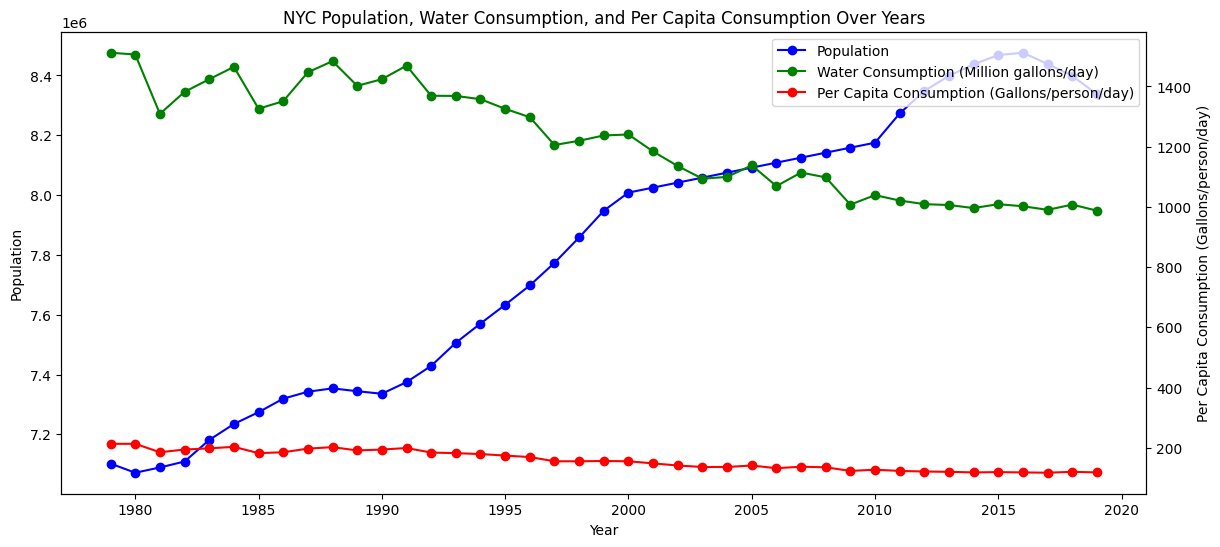

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Primary y-axis for Population
ax1.plot(data['Year'], data['Population'], marker='o', color='blue', label='Population')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population')
ax1.tick_params(axis='y')

# Create a second y-axis for Water Consumption and Per Capita Consumption
ax2 = ax1.twinx()
ax2.plot(data['Year'], data['Consumption'], marker='o', color='green', label='Water Consumption (Million gallons/day)')
ax2.set_ylabel('Water Consumption (Million gallons/day)')
ax2.tick_params(axis='y')

ax2.plot(data['Year'], data['Per Capita'], marker='o', color='red', label='Per Capita Consumption (Gallons/person/day)')
ax2.set_ylabel('Per Capita Consumption (Gallons/person/day)')
ax2.tick_params(axis='y')

# Handling the legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title('NYC Population, Water Consumption, and Per Capita Consumption Over Years')
plt.show()



### Multi Scatter Plot

Creating scatter plots to visualize the relationships between population, total water consumption, and per capita consumption.

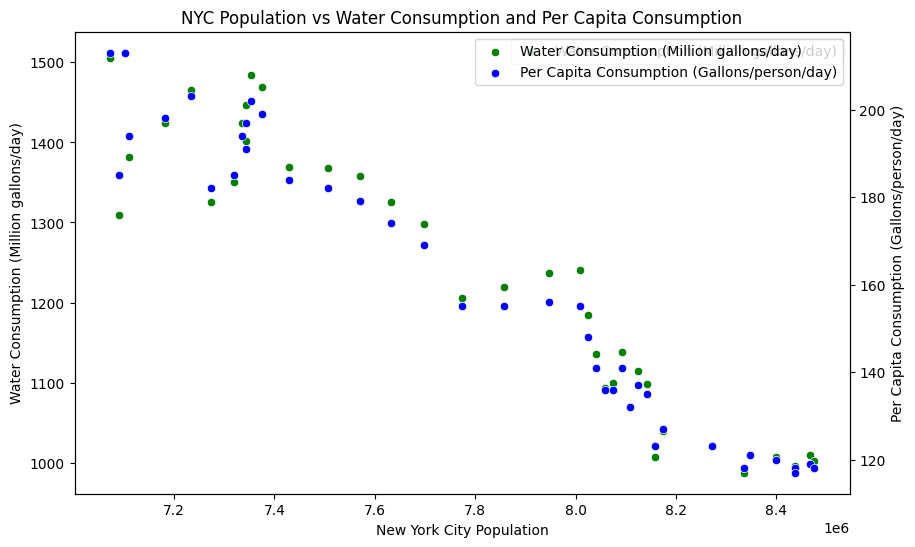

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter plot for Population vs Water Consumption
sns.scatterplot(x='Population', y='Consumption', data=data, ax=ax1, color='green', label='Water Consumption (Million gallons/day)')
ax1.set_xlabel('New York City Population')
ax1.set_ylabel('Water Consumption (Million gallons/day)')

# Create a second y-axis for Population vs Per Capita Consumption
ax2 = ax1.twinx()
sns.scatterplot(x='Population', y='Per Capita', data=data, ax=ax2, color='blue', label='Per Capita Consumption (Gallons/person/day)')
ax2.set_ylabel('Per Capita Consumption (Gallons/person/day)')


# Handling the legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title('NYC Population vs Water Consumption and Per Capita Consumption')
plt.show()


### Correlation Matrix

Analyzing the correlation between different variables in the dataset.

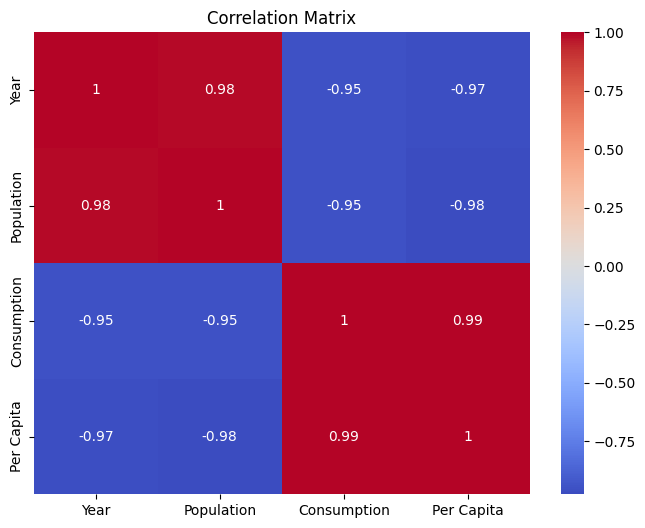

In [ ]:
# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Load the data
file_path = 'waterconsumption.csv'
data = pd.read_csv(file_path)

In [ ]:
# Extract relevant columns
forecast_data = data[['Year', 'Consumption']].set_index('Year')

# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(forecast_data)

In [ ]:
# Function to create a dataset suitable for LSTM training
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
# Define the look_back period
look_back = 3
X, y = create_dataset(scaled_data, look_back)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshaping input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# LSTM model creation function to accept input_shape
def create_lstm_model(units=50, dropout_rate=0.2, input_shape=(1,1)):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
# Define hyperparameters to tune
units_options = [50, 100]
dropout_options = [0.1, 0.3]
batch_sizes = [10, 25]
epochs_options = [10, 300]

# Placeholder for the best model and its performance
best_model = None
best_performance = float('inf')
best_params = {}

# Iterate over all combinations of hyperparameters
for units in units_options:
    for dropout_rate in dropout_options:
        for batch_size in batch_sizes:
            for epochs in epochs_options:
                # Create and train the model
                model = create_lstm_model(units, dropout_rate, (X_train.shape[1], 1))
                model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

                # Evaluate the model
                performance = model.evaluate(X_test, y_test, verbose=0)

                # Update the best model if current model is better
                if performance < best_performance:
                    best_performance = performance
                    best_model = model
                    best_params = {'units': units, 'dropout_rate': dropout_rate, 'batch_size': batch_size, 'epochs': epochs}

print("Best Model Parameters:", best_params)
print("Best Model Performance:", best_performance)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best Model Parameters: {'units': 50, 'dropout_rate': 0.3, 'batch_size': 25, 'epochs': 300}
Best Model Performance: 0.00021800170361530036


In [ ]:
# Generate predictions
predicted = best_model.predict(X_test)

# Inverse transform predictions and actual values
predicted_inverse = scaler.inverse_transform(predicted.reshape(-1, 1))
actual_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame for visualization
results = pd.DataFrame({
    'Actual': actual_inverse.flatten(),
    'Predicted': predicted_inverse.flatten()
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


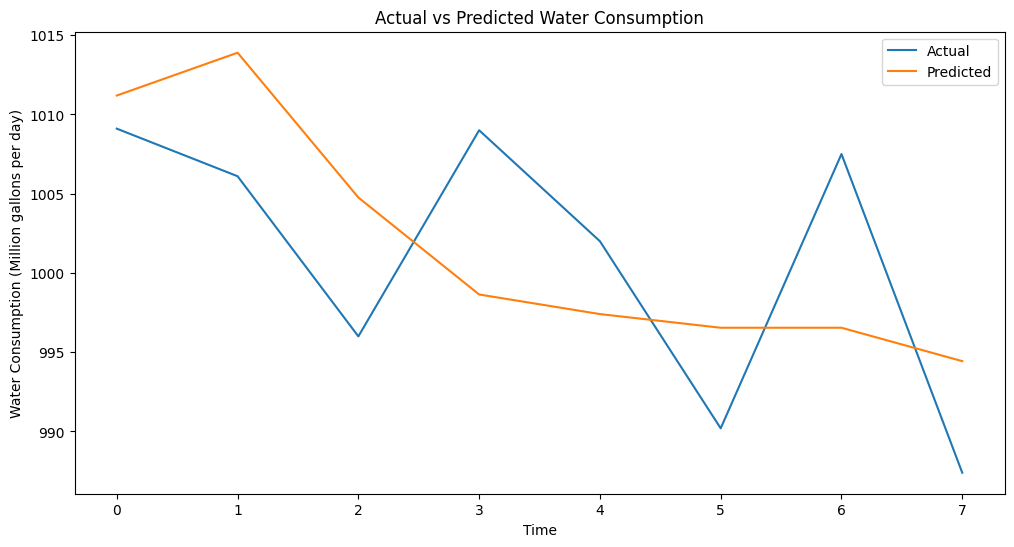

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(results['Actual'], label='Actual')
plt.plot(results['Predicted'], label='Predicted')
plt.title('Actual vs Predicted Water Consumption')
plt.xlabel('Time')
plt.ylabel('Water Consumption (Million gallons per day)')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib

# Load dataset
url = "waterconsumption.csv"  # replace with the actual path
data = pd.read_csv(url)

# Preprocessing
data['Year'] = data['Year'].astype(int)
data['Population'] = data['Population'].astype(float)
data['Consumption'] = data['Consumption'].astype(float)
data['Per Capita'] = data['Per Capita'].astype(float)

# Features and target variable
X = data[['Year', 'Population', 'Per Capita']]  # Features
y = data['Consumption']  # Target

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_dim=X_train.shape[1]),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Save the model and scaler
model.save('water_consumption_model.keras')  # Saving model as .keras
joblib.dump(scaler, 'scaler.pkl')  # Save the scaler


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1567373.8750 - val_loss: 1472605.8750
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 1567280.3750 - val_loss: 1472543.2500
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1567187.8750 - val_loss: 1472480.3750
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1567096.0000 - val_loss: 1472417.2500
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 1567002.2500 - val_loss: 1472354.0000
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 1566908.7500 - val_loss: 1472292.6250
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1566815.6250 - val_loss: 1472233.7500
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 1566725.0000 - val_loss: 1472175.7500
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1566635.5000 - val_loss: 1472120.0000
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1566549.7500 - val_loss: 1472065.8750
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 15

['scaler.pkl']